# (PART 2) ML Experiment with MLFlow

MLflow is an open source platform for managing the end-to-end machine learning lifecycle. It tackles four primary functions:

1. Tracking experiments to record and compare parameters and results (MLflow Tracking).
2. Packaging ML code in a reusable, reproducible form in order to share with other data scientists or transfer to production (MLflow Projects).
3. Managing and deploying models from a variety of ML libraries to a variety of model serving and inference platforms (MLflow Models).
4. Providing a central model store to collaboratively manage the full lifecycle of an MLflow Model, including model versioning, stage transitions, and annotations (MLflow Model Registry).

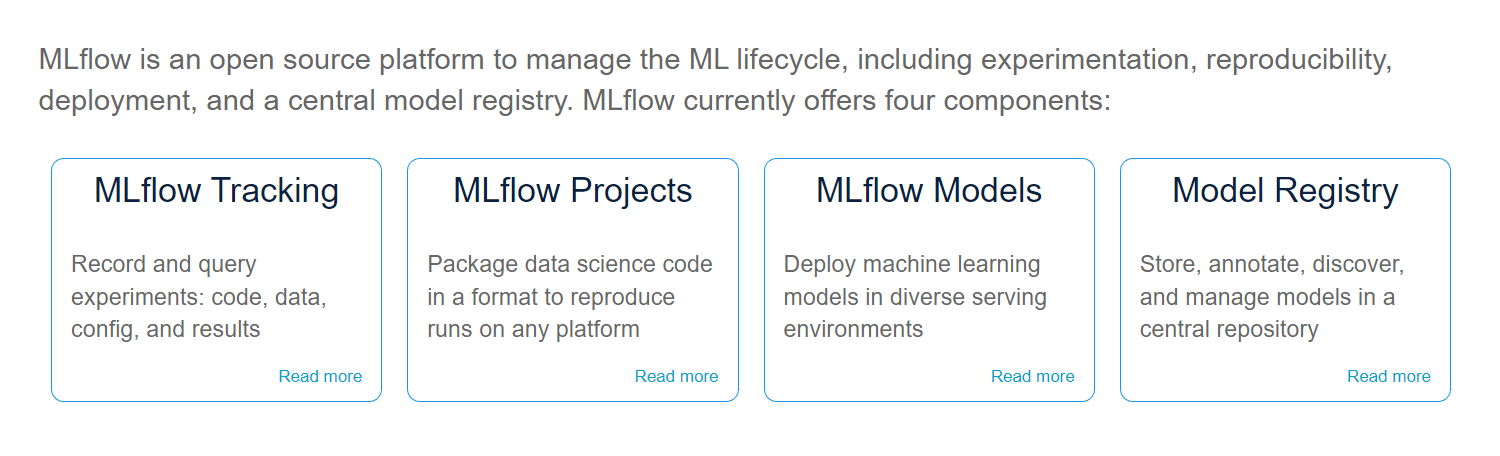

In [2]:
# check env and python version
import sys
from platform import python_version
print(f"Current environment: {sys.executable}")
print(f"Current Python Version: {python_version()}")

Current environment: /home/master/anaconda3/envs/mlops/bin/python
Current Python Version: 3.10.6


## Data Preparation

In [3]:
import os
import glob
import pandas as pd
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
# functions for data preparation
def read_files(path):
    '''Read multiple files
    '''
    df_all = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in df_all), ignore_index=True)
    return df

def is_null(df):
    '''Check NaN values
    '''
    df = pd.DataFrame(df.isnull().sum(), columns=['Null Values'])
    return df

def format_col(df):
    '''Reformat date and time column to datetime
    '''
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    return df

def add_features(df):
    '''Split date and time columns to add more features
    '''
    df['year'] = df['trans_date_trans_time'].dt.year
    df['month'] = df['trans_date_trans_time'].dt.month
    df['day'] = df['trans_date_trans_time'].dt.day
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['minute'] = df['trans_date_trans_time'].dt.minute
    df['second'] = df['trans_date_trans_time'].dt.second
    df['year_birth'] = df['dob'].dt.year
    df['month_birth'] = df['dob'].dt.month
    df['day_birth'] = df['dob'].dt.day
    return df

def data_cleaning(df):
    '''Drop unnecessary columns
    '''
    col = ['_c0', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'dob', 'trans_num', 'unix_time']
    df = df.drop(columns=col)
    return df

def encode(df):
    '''Encode objects columns
    '''
    le = LabelEncoder()
    col = [col for col in df.select_dtypes(include=['object'])]
    df[col] = le.fit_transform(col)
    return df

def split_data(df):
    '''Split data for model training and unseen data for predicition
    '''
    partition = int(0.80 * len(df))
    model_df = pd.DataFrame(df.iloc[:partition, :])
    unseen_df = pd.DataFrame(df.iloc[partition:, :]).reset_index(drop=True)
    print(f"Size of model_data: {model_df.shape}")
    print(f"Size of unseen_data : {unseen_df.shape}")
    return model_df, unseen_df

def target(df):
    '''Split model data to target
    '''
    target = df.copy()['is_fraud']
    return target
    
def features(df):
    '''Split model data to labels'''
    features = df.drop(columns='is_fraud')
    return features

def smote(features, target):
    '''Fix imbalance data'''
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    features_res, target_res = sm.fit_resample(features, target)
    return features_res, target_res

def train_test_split(features, target):
    '''Split to train and test'''
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1234)
    print(f"Train size: {X_train.shape}, {y_train.shape}")
    print(f"Test size: {X_test.shape}, {y_test.shape}")
    return X_train, X_test, y_train, y_test


In [5]:
path = "/home/master/projects/mlflow/HDFSfile/fraud"
df = read_files(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   _c0                    int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [6]:
# check data imblance
df['is_fraud'].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [7]:
df_null = is_null(df)
df_null

,Null Values
_c0,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


In [8]:
df = format_col(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   _c0                    int64         
 1   trans_date_trans_time  datetime64[ns]
 2   cc_num                 int64         
 3   merchant               object        
 4   category               object        
 5   amt                    float64       
 6   first                  object        
 7   last                   object        
 8   gender                 object        
 9   street                 object        
 10  city                   object        
 11  state                  object        
 12  zip                    int64         
 13  lat                    float64       
 14  long                   float64       
 15  city_pop               int64         
 16  job                    object        
 17  dob                    datetime64[ns]
 18  trans_num             

In [9]:
df = add_features(df)

In [10]:
df = data_cleaning(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column       Dtype  
---  ------       -----  
 0   merchant     object 
 1   category     object 
 2   amt          float64
 3   gender       object 
 4   city         object 
 5   state        object 
 6   zip          int64  
 7   lat          float64
 8   long         float64
 9   city_pop     int64  
 10  job          object 
 11  merch_lat    float64
 12  merch_long   float64
 13  is_fraud     int64  
 14  year         int64  
 15  month        int64  
 16  day          int64  
 17  hour         int64  
 18  minute       int64  
 19  second       int64  
 20  year_birth   int64  
 21  month_birth  int64  
 22  day_birth    int64  
dtypes: float64(5), int64(12), object(6)
memory usage: 325.1+ MB


In [11]:
df = encode(df)

In [12]:
df, unseen_df = split_data(df)

Size of model_data: (1481915, 23)
Size of unseen_data : (370479, 23)


In [13]:
unseen_df.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,...,is_fraud,year,month,day,hour,minute,second,year_birth,month_birth,day_birth
0,4,0,52.43,2,1,5,34668,28.3011,-82.6927,42619,...,0,2019,6,16,5,36,4,1975,10,7
1,4,0,83.00,2,1,5,36541,30.4983,-88.3282,15647,...,0,2019,6,16,5,36,5,1957,12,26
2,4,0,62.17,2,1,5,87543,36.1486,-105.6648,247,...,0,2019,6,16,5,36,8,1961,10,24
3,4,0,33.72,2,1,5,20895,39.0298,-77.0793,19054,...,0,2019,6,16,5,36,12,1976,9,8
4,4,0,172.83,2,1,5,66018,38.9462,-94.9714,5760,...,0,2019,6,16,5,36,33,1978,10,1


In [14]:
target = target(df)
features = features(df)
print(f"Original dataset {features.shape}, {target.shape}")

Original dataset (1481915, 22), (1481915,)


In [15]:
features_res, target_res = smote(features, target)
print(f'Resampled dataset shape %s' % Counter(target_res))

Resampled dataset shape Counter({0: 1474110, 1: 1474110})


In [16]:
X_train, X_test, y_train, y_test = train_test_split(features_res, target_res)

Train size: (2063754, 22), (2063754,)
Test size: (884466, 22), (884466,)


## Model Training Tracking MLflow

In [17]:
# create artificat repo
artifact_path = '/home/master/projects/mlflow/mlflow-run'

if not os.path.exists(artifact_path):
    print(f"Setting up artifact folder for you...")
    time.sleep(3)
    os.makedirs(artifact_path)
    print(f"Successfully created artifcat folder at {artifact_path} directory")
else:
    print(f"Folder already exist! Using {artifact_path} directory")

Folder already exist! Using /home/master/projects/mlflow/mlflow-run directory


In [18]:
# create image folder
image_path = '/home/master/projects/mlflow/images'

if not os.path.exists(image_path):
    print(f"Setting up image folder for you...")
    time.sleep(3)
    os.makedirs(image_path)
    print(f"Successfully created image folder at {image_path} directory")
else:
    print(f"Folder already exist! Using {image_path} directory")

Folder already exist! Using /home/master/projects/mlflow/images directory


create env packages as requirement.txt 

In the terminal run:

conda list -e > requirements.txt

 ***NOTES*** : **Run mlflow ui or mlflow server before execute this cell!**

**Storage: MLflow tracking server has two components for storage: a backend store and an artifact store.**

**Backend Stores**

The backend store is where MLflow Tracking Server stores experiment and run metadata as well as params, metrics, and tags for runs. MLflow supports two types of backend stores: file store and database-backed store.

1. By default, A file store backend as ./path_to_store or file:/path_to_store 
2. A database-backed store as SQLAlchemy database URI. The database URI typically takes the format <dialect>+<driver>://<username>:<password>@<host>:<port>/<database>. MLflow supports the database dialects mysql, mssql, sqlite, and postgresql

**Artifact Stores**
    
You can stores all the non-structured data of the experiment such as training-validation curve etc in the local path and also backend storage. MLflow support backend storage:

1. Amazon S3 and S3-compatible storage
2. Azure Blob Storage
3. Google Cloud Storage
4. FTP server
5. SFTP Server
6. NFS
7. HDFS





### Run with Backend store

mlflow server \
    --backend-store-uri mysql+pymysql://'username':'password'@'localhost':3306/mlflow \
    --default-artifact-root /home/master/projects/mlflow/mlflow-run \
    --host 127.0.0.1 \
    --port 5000

In [19]:
experiment_name = input("Enter your experiment name: ")
artifact_repository = artifact_path

# Provide uri and connect to your tracking server
mlflow.set_tracking_uri('http://localhost:5000/')

# Initialize MLflow client
client = MlflowClient()

try:
    # Create experiment 
    experiment_id = client.create_experiment(experiment_name, artifact_location=artifact_repository)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

In [22]:
def model_experimentation(classifier, param, model_name, run_name):
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        run_id = run.info.run_uuid

        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "This is experiment for exploring different machine learning models for Fraud Dataset")

        mlflow.sklearn.autolog()

        tags = {"Application": "Fraud Prediction Platform",
                "release.candidate": "FPP",
                "release.version": "1.0.0"}
        
        mlflow.set_tags(tags)
                        
        mlflow.log_artifact('requirements.txt')
        
        # Perform model training
        clf = classifier(**param)
        clf.fit(X_train, y_train)

        valid_prediction = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, valid_prediction)
        roc_auc = auc(fpr, tpr) # compute area under the curve
        print("=====================================")
        print("Validation AUC:{}".format(roc_auc))
        print("=====================================")
        
        mlflow.log_metrics({"Validation_AUC": roc_auc})
   
        plot_confusion_matrix(clf, X_test, y_test, 
                              display_labels=['Fraud', 'Not Fraud'],
                              cmap='magma')
        plt.title('Confusion Matrix')
        filename = f'./images/{model_name}_validation_confusion_matrix.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename) 

        plot_roc_curve(clf, X_test, y_test, name='Validation')
        plt.title('ROC AUC Curve')
        filename = f'./images/{model_name}_validation_roc_curve.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename) 

## Logistic Regression Training and evaluation + MLFlow for model tracking

2022/11/03 23:05:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Validation AUC:0.8694499734068241


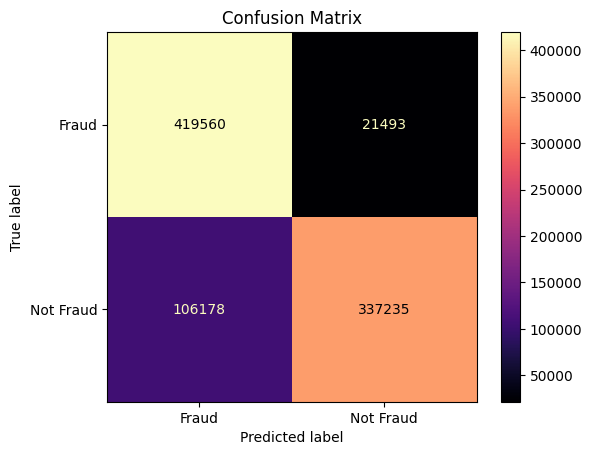

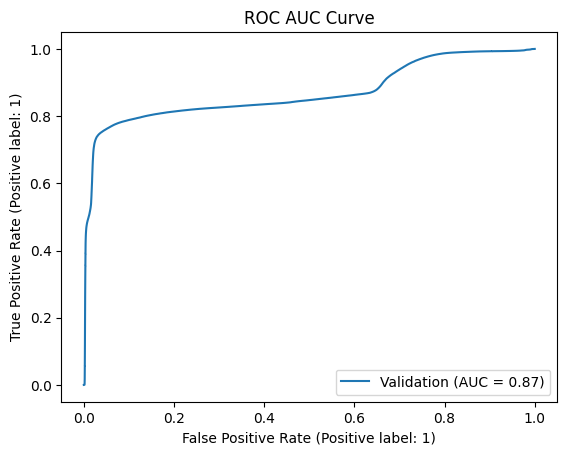

In [23]:
classifier = LogisticRegression
param = {"C":1, "random_state":20}
model_name = 'Lt'
run_name = 'LogisticRegression_model'
model_experimentation(classifier, param, model_name, run_name)

## Decision Tree Training and evaluation + MLFlow for model tracking

In [24]:
classifier = DecisionTreeClassifier
param = {"max_depth":3, "random_state":20}
model_name = 'dt'
run_name = 'DecisionTree_model'
model_experimentation(classifier, param, model_name, run_name)

2022/11/03 23:06:02 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Validation AUC:0.9102968541470866


## Random Forest Training and evaluation + MLFlow for model tracking

In [25]:
classifier = RandomForestClassifier
param = {"max_depth":3, "random_state":20}
model_name = 'rf'
run_name = 'randomForest_model'
model_experimentation(classifier, param, model_name, run_name)

2022/11/03 23:06:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Validation AUC:0.923106456764252


## Gradient Boosting Training and evaluation + MLFlow for model tracking

In [26]:
classifier = GradientBoostingClassifier
param = {"max_depth":3, "random_state":20}
model_name = 'gbm'
run_name = 'GradientBoosting_model'
model_experimentation(classifier, param, model_name, run_name)

2022/11/03 23:10:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Validation AUC:0.9612338513787285


## Lightgbm Training and evaluation + MLFlow for model tracking

In [27]:
with mlflow.start_run(experiment_id=experiment_id, run_name='Lightgbm_model') as run:
    run_id = run.info.run_uuid

    MlflowClient().set_tag(run_id,
                           "mlflow.note.content",
                           "This is experiment for exploring different machine learning models for Fraud Dataset")
     
    # Define tag
    tags = {"Application": "Fraud Prediction Platform",
            "release.candidate": "FPP",
            "release.version": "1.0.0"}
            
    mlflow.set_tags(tags)
    
    mlflow.log_artifact('requirements.txt')

    # Define model parameter
    params = {
        "objective": "binary",
        "learning_rate": 0.05,
        "metric": "auc",
        "colsample_bytree": 0.7,
        "subsample": 0.8,
        "seed": 42,
    }
        
    mlflow.log_params(params)
    
    # Perform model training
    lgb_clf = LGBMClassifier(**params)
    lgb_clf.fit(X_train, y_train, 
                eval_set = [(X_train, y_train), (X_test, y_test)], 
                early_stopping_rounds=50,
                verbose=20)
        
    mlflow.sklearn.log_model(lgb_clf, "model")
     
    lgb_valid_prediction = lgb_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, lgb_valid_prediction)
    roc_auc = auc(fpr, tpr) # compute area under the curve
    print("=====================================")
    print("Validation AUC:{}".format(roc_auc))
    print("=====================================")   
        
    # log metrics
    mlflow.log_metrics({"Validation_AUC": roc_auc})
       
    # Plot and save feature importance details
    ax = plot_importance(lgb_clf, height=0.4)
    filename = './images/lgb_validation_feature_importance.png'
    plt.savefig(filename)
    # log model artifacts
    mlflow.log_artifact(filename)
    
    ax = plot_metric(lgb_clf.evals_result_)
    filename = './images/lgb_validation_metrics_comparision.png'
    plt.savefig(filename)
    # log model artifacts
    mlflow.log_artifact(filename)
    
    # Plot and save metrics details    
    plot_confusion_matrix(lgb_clf, X_test, y_test, 
                          display_labels=['Fraud', 'Not Fraud'],
                          cmap='magma')
    plt.title('Confusion Matrix')
    filename = './images/lgb_validation_confusion_matrix.png'
    plt.savefig(filename)
    # log model artifacts
    mlflow.log_artifact(filename)
    
    # Plot and save AUC details  
    plot_roc_curve(lgb_clf, X_test, y_test, name='Validation')
    plt.title('ROC AUC Curve')
    filename = './images/lgb_validation_roc_curve.png'
    plt.savefig(filename)
    # log model artifacts
    mlflow.log_artifact(filename)

[20]	training's auc: 0.961157	valid_1's auc: 0.961154
[40]	training's auc: 0.964668	valid_1's auc: 0.964646
[60]	training's auc: 0.967524	valid_1's auc: 0.967522
[80]	training's auc: 0.969557	valid_1's auc: 0.969552
[100]	training's auc: 0.972687	valid_1's auc: 0.972679
Validation AUC:0.9726789203373347


## Register the best model

In [28]:
# model_uri = "runs:/{}/model".format(run.info.run_id)
model_uri = f"runs:/{run.info.run_id}/model"
mv = mlflow.register_model(model_uri, "Lightgbm_model")
print(f"Successfully registered your best model:")
print(f"Name: {mv.name}")
print(f"Version: {mv.version}")      

Successfully registered model 'Lightgbm_model'.
2022/11/03 23:26:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Lightgbm_model, version 1


Successfully registered your best model:
Name: Lightgbm_model
Version: 1


Created version '1' of model 'Lightgbm_model'.


## Prediction with Registered Model

In [29]:
unseen_df.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,...,is_fraud,year,month,day,hour,minute,second,year_birth,month_birth,day_birth
0,4,0,52.43,2,1,5,34668,28.3011,-82.6927,42619,...,0,2019,6,16,5,36,4,1975,10,7
1,4,0,83.00,2,1,5,36541,30.4983,-88.3282,15647,...,0,2019,6,16,5,36,5,1957,12,26
2,4,0,62.17,2,1,5,87543,36.1486,-105.6648,247,...,0,2019,6,16,5,36,8,1961,10,24
3,4,0,33.72,2,1,5,20895,39.0298,-77.0793,19054,...,0,2019,6,16,5,36,12,1976,9,8
4,4,0,172.83,2,1,5,66018,38.9462,-94.9714,5760,...,0,2019,6,16,5,36,33,1978,10,1


In [37]:
target_actual = pd.Series(unseen_df.copy()['is_fraud'])
features_actual = unseen_df.drop(columns=['is_fraud'])
print(f"Original dataset {target_actual.shape}, {features_actual.shape}")

Original dataset (370479,), (370479, 22)


In [32]:
target_actual.head()

0    0
1    0
2    0
3    0
4    0
Name: target_act, dtype: int64

In [34]:
import mlflow.pyfunc

model_name = "Lightgbm_model"
model_version = 1

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

target_pred = pd.Series(model.predict(features_actual)).rename("target_pred")
print(target_pred.head())

0    0
1    0
2    0
3    0
4    0
Name: target_pred, dtype: int64


In [35]:
df_concat = pd.concat([target_actual, target_pred], axis=1, ignore_index=True)
df_concat.head()

,0,1
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


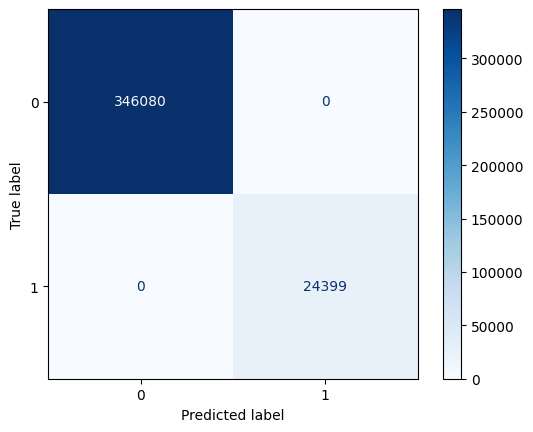

In [40]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(lgb_clf, features_actual, target_pred, cmap=plt.cm.Blues)
plt.show()

### --- End of Notebook ---